In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dataclasses import dataclass, asdict, field
from tqdm import trange 
import tensorflow_datasets as tfds

In [2]:
# paths = tf.io.gfile.glob('../input/imagenette/imagenette/train/*/*')

In [3]:
data = tfds.load('imagenette/160px-v2')

2022-10-09 17:32:11.789348: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling imagenette-train.tfrecord...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling imagenette-validation.tfrecord...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/160px-v2/1.0.0. Subsequent calls will reuse this data.


2022-10-09 17:32:23.345040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 17:32:23.437179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 17:32:23.437954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 17:32:23.440261: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
train_data = data['train']

In [5]:
masked_imgs = []
masks = []
for item in train_data.take(1000):
    img = item['image'].numpy()
    img = cv2.resize(img, [160, 160])
    mask = np.array(np.random.choice(a=[0, 1], size=(160, 160, 1), p=[0.9, 0.1]), dtype='uint8')
    mask = tf.repeat(mask, repeats=3, axis=-1).numpy()
    masked_img = np.array(mask*img/255, dtype='float32')
    masked_imgs.append(masked_img)
    masks.append(np.array(mask, dtype='float32'))

2022-10-09 17:32:26.051665: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-09 17:32:30.847234: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
masked_imgs[0].shape

(160, 160, 3)

In [7]:
# crop = tf.keras.layers.Cropping2D(160)
# def _read(path):
#     image = tf.io.read_file(path)
#     image = tf.io.decode_jpeg(image, channels=1)
#     image = tf.image.resize(image, [160, 160])
#     image= tf.cast(image, tf.uint8)
#     mask = np.array(np.random.choice(a=[0, 1], size=(160, 160, 1), p=[0.7, 0.3]), dtype='uint8')
# #     mask = tf.repeat(mask, repeats=3, axis=-1)
#     masked_img = tf.math.multiply(mask, image)
#     return tf.cast(mask, tf.float32), tf.cast(masked_img, tf.float32)/255.0


In [8]:
def _preprocess(mask, masked_img):
    return tf.cast(mask, tf.float32), tf.cast(masked_img, tf.float32)/255.0

In [9]:
train_data = tf.data.Dataset.from_tensor_slices((masks, masked_imgs))
train_data = train_data.shuffle(1000).cache()
train_data = train_data.batch(64)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [10]:
class InpaintingRemask(tf.keras.layers.Layer):
    def __init__(self, name):
        super(InpaintingRemask, self).__init__(name=name)
    def call(self, u, mask, f):
        return tf.math.multiply(f, mask) + tf.math.multiply(u, (1 - mask))

In [11]:
class Model():
    def LaplacianInitialiser(self, depth):
        def LaplacianInitialiser(shape, dtype=tf.float32):
            """
            Sobel-X Kernel
            """
            
            laplacian = tf.constant(
                [
                    [0, 1, 0], 
                    [1, -4, 1], 
                    [0, 1, 0], 
                ], dtype=dtype )
            laplacian = tf.reshape(laplacian, (3, 3, 1, 1))
            laplacian = tf.tile(laplacian, (1, 1, depth, 1))
            return laplacian

        return LaplacianInitialiser
    
    def SobelXInitialiser(self, depth):
        def SobelXInitialiser(shape, dtype=tf.float32):
            """
            Sobel-X Kernel
            """
            
            sobel_x = tf.constant(
                [
                    [1, 0, -1], 
                    [2, 0, -2], 
                    [1, 0, -1], 
                ], dtype=dtype )
            sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))
            sobel_x = tf.tile(sobel_x, (1, 1, depth, 1))
            return sobel_x

        return SobelXInitialiser

    def SobelYInitialiser(self, depth):
        def SobelYInitialiser(shape, dtype=tf.float32):
            """
            Sobel-Y Kernel
            """
            
            sobel_y = tf.constant(
                [
                    [1, 2, 1], 
                    [0, 0, 0], 
                    [-1, -2, -1], 
                ], dtype=dtype )
            sobel_y = tf.reshape(sobel_y, (3, 3, 1, 1))
            sobel_y = tf.tile(sobel_y, (1, 1, depth, 1))
            return sobel_y
        
        return SobelYInitialiser
    def SobelXXInitialiser(self, depth):
        def SobelXXInitialiser(shape, dtype=tf.float32):
            """
            Sobel-X Kernel
            """
            
            sobel_x = tf.constant(
                [
                    [1, -2, 1], 
                    [2, -4, 2], 
                    [1, -2, 1], 
                ], dtype=dtype )
            sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))
            sobel_x = tf.tile(sobel_x, (1, 1, depth, 1))
            return sobel_x

        return SobelXXInitialiser

    def SobelYYInitialiser(self, depth):
        def SobelYYInitialiser(shape, dtype=tf.float32):
            """
            Sobel-Y Kernel
            """
            
            sobel_y = tf.constant(
                [
                    [1, 2, 1], 
                    [-2, -4, -2], 
                    [1, 2, 1], 
                ], dtype=dtype )
            sobel_y = tf.reshape(sobel_y, (3, 3, 1, 1))
            sobel_y = tf.tile(sobel_y, (1, 1, depth, 1))
            return sobel_y
        
        return SobelYYInitialiser
    def encoder_blk(self, inp: tf.Tensor, layers: int=2, filters: int=32, 
                    pool: bool=True, activation=None, residual=True):
        """
        Encoder Block
        """
        
        node_inp = tf.keras.layers.Conv2D(filters, (1, 1), activation=activation, padding='SAME')(inp)
        node = tf.keras.layers.Conv2D(filters, (3, 3), activation=activation, padding='SAME')(node_inp)
        for i in range(layers-1):
            node = tf.keras.layers.Conv2D(filters, (3, 3), activation=activation, padding='SAME')(node)
            
        if residual:
            node = tf.keras.layers.Add()([node, node_inp])
            
        if pool:
            pool = tf.keras.layers.AveragePooling2D()(node)
            
        return node, pool

    def decoder_blk(self, inp: tf.Tensor, node: tf.Tensor, layers: int=2, filters: int=32, 
                    pool: bool=True, activation=None, residual=True):
        """
        Decoder Block
        """
        
        conv =  tf.keras.layers.Conv2D(filters, (3, 3), activation=activation, padding='SAME')(inp)
        for i in range(layers-1):
            conv = tf.keras.layers.Conv2D(filters, (3, 3), activation=activation, padding='SAME')(conv)
            
        ups = tf.keras.layers.UpSampling2D(interpolation='bilinear')(conv)
        
        return tf.keras.layers.concatenate([ups, node], axis=-1)
    
    def mini_u_net(self, inp, activation=None):
        """
        FlowNetSimple-UNet-like Architecture with Residuals Connections.
        """
        
        conv0 = tf.keras.layers.Conv2D(32, (5, 5), activation=activation, padding='SAME')(inp)
        
        # Encoder Blocks
        conv1, pool0 = self.encoder_blk(conv0, layers=2, filters=32, activation=activation, residual=True)
        conv2, pool1 = self.encoder_blk(pool0, layers=2, filters=64, activation=activation, residual=True)
        conv3, pool2 = self.encoder_blk(pool1, layers=2, filters=128, activation=activation, residual=True)
        
        # Pipe
        conv = tf.keras.layers.Conv2D(256, (3, 3), activation=activation, padding='SAME')(pool2)
        conv = tf.keras.layers.Conv2D(256, (3, 3), activation=activation, padding='SAME')(conv)
        
        # Decoder Blocks
        concat = self.decoder_blk(conv, node=conv3, layers=2, filters=128, activation=activation)
        concat = self.decoder_blk(concat, node=conv2, layers=2, filters=64, activation=activation)
        concat = self.decoder_blk(concat, node=conv1, layers=2, filters=32, activation=activation)
        
        # Garnishing
        deconv3 =  tf.keras.layers.Conv2D(24, (3, 3), activation=activation, padding='SAME')(concat)
        deconv3 =  tf.keras.layers.Conv2D(12, (3, 3), activation=activation, padding='SAME')(deconv3)
        deconv3 =  tf.keras.layers.Conv2D(6, (3, 3), activation=activation, padding='SAME')(deconv3)
        deconv3 =  tf.keras.layers.Conv2D(3, (3, 3), activation=activation, padding='SAME', name='output')(deconv3)

        return deconv3
    
    def diff(self, inp: tf.Tensor, depthwise_initializer_x, depthwise_initializer_y, name):
        """
        Differentiator: Perform x- and y- directional differentiation
        Inputs:
            Shape: (BATCH_SIZE, X, Y, C)
        Outputs:
            Depthwise concatenation in the order [dx, dy] where dx, and dy both have same channels as the inputs
            Shape: [(BATCH_SIZE, X, Y, C), (BATCH_SIZE, X, Y, C)] = (BATCH_SIZE, X, Y, 2*C)
        """
        
        # x-derivative
        xdiff = tf.keras.layers.DepthwiseConv2D((3, 3), (1, 1), depthwise_initializer=depthwise_initializer_x, 
                                                use_bias=None, trainable=False, padding='VALID', name=name+'_x')(inp)
        xdiff = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(xdiff)
        
        # y-derivative
        ydiff = tf.keras.layers.DepthwiseConv2D((3, 3), (1, 1), depthwise_initializer=depthwise_initializer_y, 
                                                use_bias=None, trainable=False, padding='VALID', name=name+'_y')(inp)
        ydiff = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(ydiff)
        
        return tf.keras.layers.concatenate([xdiff, ydiff], axis=-1)
    
    def laplacian(self, inp: tf.Tensor, input_depth: int=3):
        laplacian = tf.keras.layers.DepthwiseConv2D((3, 3), (1, 1), depthwise_initializer=self.LaplacianInitialiser(input_depth), 
                                                use_bias=None, trainable=False, padding='VALID')(inp)
        laplacian = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(laplacian)

        
        return laplacian
    
    def build_network(self, input_depth: int=3):
        
        inp = tf.keras.Input((160, 160, input_depth))
        mask = tf.keras.Input((160, 160, input_depth))
        out = self.mini_u_net(inp, activation=None)
        out = InpaintingRemask(name='remask')(out, mask, inp)
        laplacian = self.laplacian(out)
        diff1 = self.diff(out, self.SobelXInitialiser(input_depth), self.SobelYInitialiser(input_depth), 'sobel1')
        diff2 = self.diff(out, self.SobelXXInitialiser(input_depth), self.SobelYYInitialiser(input_depth), 'sobel2')
        model = tf.keras.Model(inputs=[mask, inp], outputs=[out, laplacian, diff1, diff2])
        return model
        

In [12]:
model = Model().build_network()
model.summary()
# tf.keras.utils.plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 1056        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 160, 160, 32) 9248        conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
@dataclass
class Settings:
    name: str
    lr: float=0.0008
    lr_decay: float=0.8
    patience: int=12
    epochs: int=1000
    alpha: float=0.01
    def dict(self):
        return {k: str(v) for k, v in asdict(self).items()}

In [14]:

def neural_surrogate_loss(pred, batch):
    u_f = pred[0] - batch[1]
    data_term = batch[0] * u_f
    
    
    smoothness_term = (1 - batch[0]) * pred[1]
    
#     loss = tf.norm(, axis=[-3, -2]) ** 2
    loss_sum = tf.reduce_sum((data_term - smoothness_term)**2, axis=[-1, -2, -3])
    loss_sqrt = loss_sum
    loss = tf.reduce_mean(loss_sqrt)
    residual_sum_per_channel = tf.reduce_sum((1-batch[0]) * (pred[1]**2), axis=[-3, -2])
    residual_per_channel = tf.sqrt(residual_sum_per_channel)/(160*160)
    residual_sum = tf.reduce_mean(residual_per_channel, axis=-1) 
    residual = tf.reduce_mean(residual_sum) 
    return loss, residual

def homogenous_inpainting_energy(pred, batch):
    grad_sq = tf.square(pred[2])
    smoothness = tf.norm((1-batch[0])*pred[1], axis=-1)**2
    loss = tf.reduce_sum(smoothness, axis=[-1, -2])
    return tf.reduce_mean(loss), 0

def euler_elastica(pred, batch, epsilon):
    grad_mag = tf.sqrt(tf.square(pred[2][..., 0]) + tf.square(pred[2][..., 1]) + tf.square(epsilon))
    
    
def compute_loss(pred, batch, alpha, epsilon):
    
    loss, residual = homogenous_inpainting_energy(pred, batch)
    return loss, residual

@tf.function
def train_step(batch, model, optimiser, alpha, epsilon=10e-3, train=True):
    """ 
    Single Forward and Backpropagation Step
    """
    
    with tf.GradientTape(persistent=False) as tape:
        pred = model(batch)
        energy_loss, residual = compute_loss(pred, batch, alpha, epsilon)
    
    if(train):
        grad = tape.gradient(energy_loss, model.trainable_variables)
        optimiser.apply_gradients(zip(grad, model.trainable_variables))
        
    return energy_loss, residual

def train(data, model, settings):
    """
    Training Loop
    """
    
    # Fetch config from settings
    pbar = trange(settings.epochs)
    optimiser = tf.keras.optimizers.Adam(settings.lr)
    alpha = tf.Variable(settings.alpha, trainable=False)
    patience = settings.patience
    lr_decay = settings.lr_decay
    
    losses = []
    counter = 0
    history = {'train': {'energy': []}, 'val': {'epe': []}, 'lr': []}
    for i in pbar:
        iter_losses = []
        history['lr'].append(optimiser.lr.numpy())
        for batch in data:
            loss, residual = train_step(batch, model, optimiser, alpha, train=True)
            iter_losses.append(loss)
            
        epoch_loss = tf.reduce_mean(iter_losses).numpy()
        history['train']['energy'].append(epoch_loss)
        if(min(history['train']['energy']) < epoch_loss):
            counter += 1
            
        else:
            counter = 0
            model.save('ckpt.h5')
            
        if(patience is not None and counter == patience):
            counter = 0
            optimiser.lr.assign(optimiser.lr.numpy()*lr_decay)
            print(f"Learning rate decayed to: {optimiser.lr.numpy()}, Minimum (energy) was: ({min(history['train']['energy'])})")
        pbar.set_description(f"energy:  {epoch_loss}, residual: {residual}, patience_count: {counter}")
        
    return model, history

In [15]:
settings = Settings(
    name='model.h5',
    lr=0.0001,
    lr_decay=0.8,
    patience=12,
    epochs=3000,
    alpha=0.9
)

In [16]:
model = Model().build_network()
model, history = train(train_data, model, settings)


  0%|          | 0/3000 [00:00<?, ?it/s]2022-10-09 17:33:34.243781: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
energy:  348.05682373046875, residual: 0, patience_count: 0:  31%|███▏      | 941/3000 [1:02:05<2:14:52,  3.93s/it]

Learning rate decayed to: 7.999999797903001e-05, Minimum (energy) was: (348.0361328125)


energy:  328.9292907714844, residual: 0, patience_count: 0:  44%|████▎     | 1310/3000 [1:26:22<1:49:49,  3.90s/it]

Learning rate decayed to: 6.399999983841553e-05, Minimum (energy) was: (328.77392578125)


energy:  326.0528564453125, residual: 0, patience_count: 0:  45%|████▌     | 1363/3000 [1:29:49<1:45:31,  3.87s/it]

Learning rate decayed to: 5.120000059832819e-05, Minimum (energy) was: (325.89263916015625)


energy:  318.09283447265625, residual: 0, patience_count: 0:  54%|█████▍    | 1629/3000 [1:47:16<1:28:21,  3.87s/it]

Learning rate decayed to: 4.095999975106679e-05, Minimum (energy) was: (317.86627197265625)


energy:  313.62567138671875, residual: 0, patience_count: 0:  59%|█████▉    | 1775/3000 [1:56:52<1:19:22,  3.89s/it]

Learning rate decayed to: 3.276799907325767e-05, Minimum (energy) was: (313.4114685058594)


energy:  311.0426330566406, residual: 0, patience_count: 0:  63%|██████▎   | 1882/3000 [2:03:58<1:13:58,  3.97s/it]

Learning rate decayed to: 2.6214398531010374e-05, Minimum (energy) was: (310.91259765625)


energy:  309.4837951660156, residual: 0, patience_count: 0:  65%|██████▌   | 1950/3000 [2:08:28<1:08:42,  3.93s/it]

Learning rate decayed to: 2.0971518097212538e-05, Minimum (energy) was: (309.34442138671875)


energy:  308.6248779296875, residual: 0, patience_count: 0:  67%|██████▋   | 2002/3000 [2:11:54<1:04:38,  3.89s/it]

Learning rate decayed to: 1.677721411397215e-05, Minimum (energy) was: (308.4295959472656)


energy:  309.1173095703125, residual: 0, patience_count: 0:  67%|██████▋   | 2022/3000 [2:13:15<1:07:00,  4.11s/it]

Learning rate decayed to: 1.34217716549756e-05, Minimum (energy) was: (307.95892333984375)


energy:  304.3538818359375, residual: 0, patience_count: 0:  83%|████████▎ | 2504/3000 [2:45:16<32:26,  3.92s/it]

Learning rate decayed to: 1.073741714208154e-05, Minimum (energy) was: (304.269775390625)


energy:  302.6282653808594, residual: 0, patience_count: 0:  93%|█████████▎| 2776/3000 [3:03:22<14:49,  3.97s/it]

Learning rate decayed to: 8.589933713665232e-06, Minimum (energy) was: (302.61053466796875)


energy:  302.0599060058594, residual: 0, patience_count: 0:  95%|█████████▌| 2857/3000 [3:08:43<09:15,  3.88s/it]

Learning rate decayed to: 6.8719468799827155e-06, Minimum (energy) was: (302.058349609375)


energy:  301.31353759765625, residual: 0, patience_count: 0: 100%|██████████| 3000/3000 [3:18:16<00:00,  3.97s/it]


In [17]:
def predict(model, dataset):
    preds = []
    inp = []
    for batch in dataset:
        pred = model(batch)
        preds.extend(list(pred[0].numpy()))
        inp.extend(list(batch[1].numpy()))
    return preds, inp

In [18]:
pred, inp = predict(model, train_data)

In [19]:
def plot(index):
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2, 1)
    plt.imshow(pred[index])
    plt.subplot(1,2, 2)
    plt.imshow(inp[index])

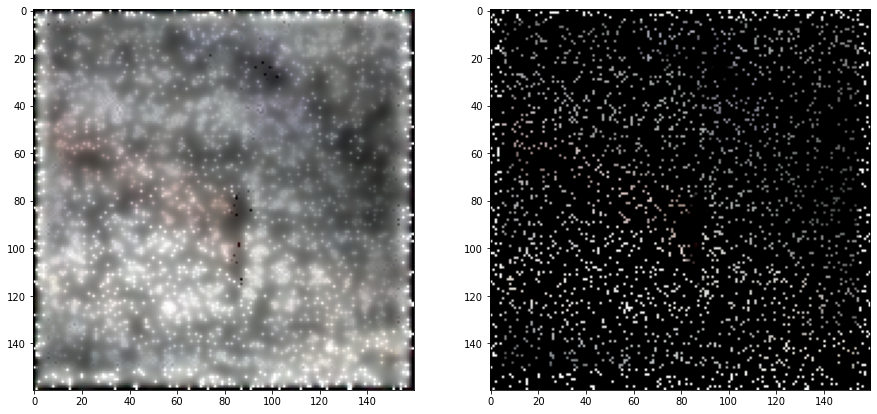

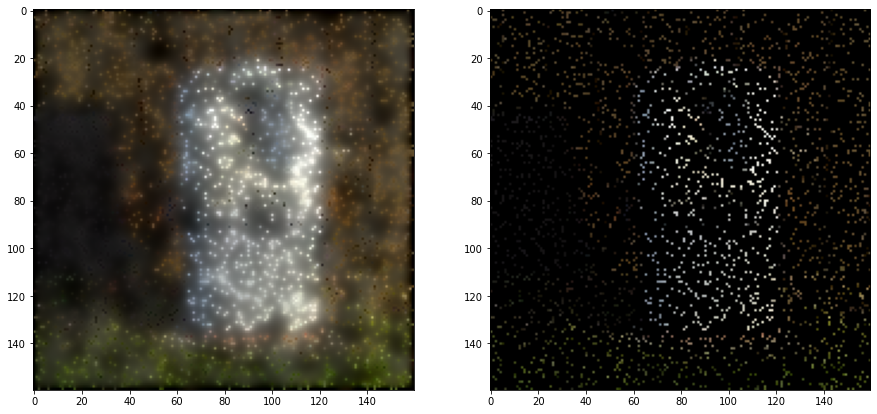

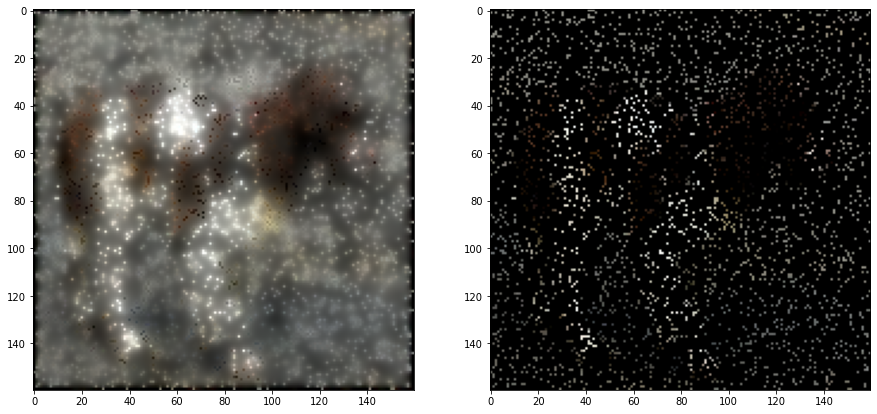

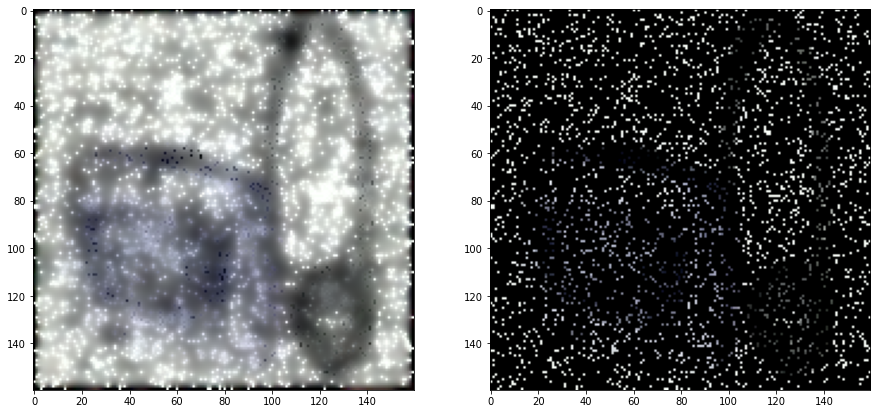

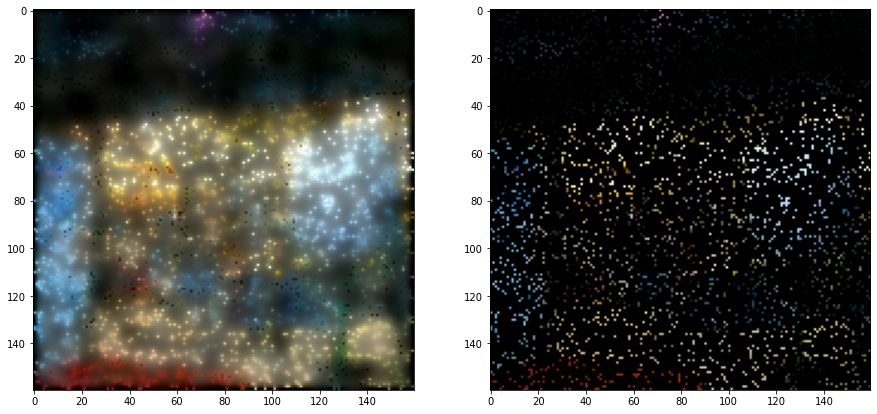

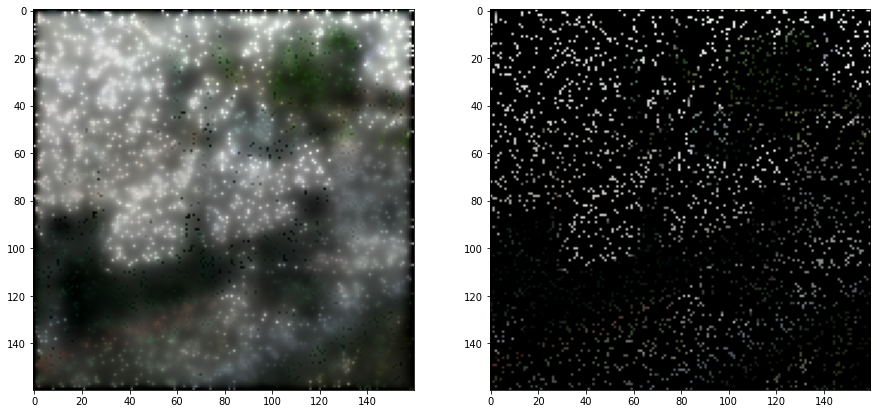

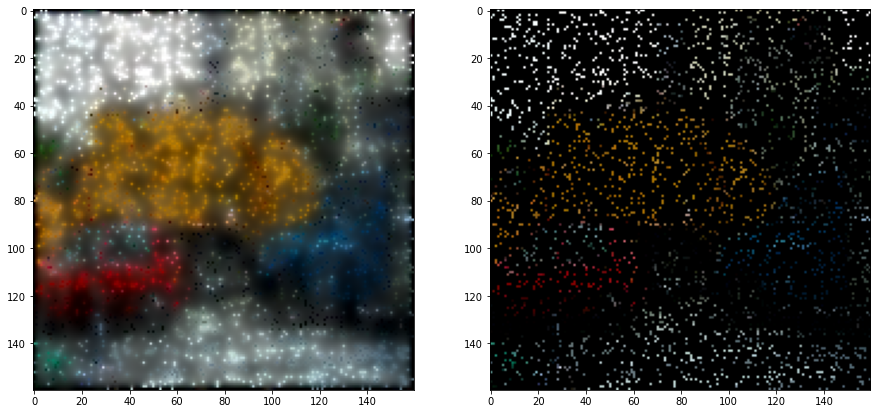

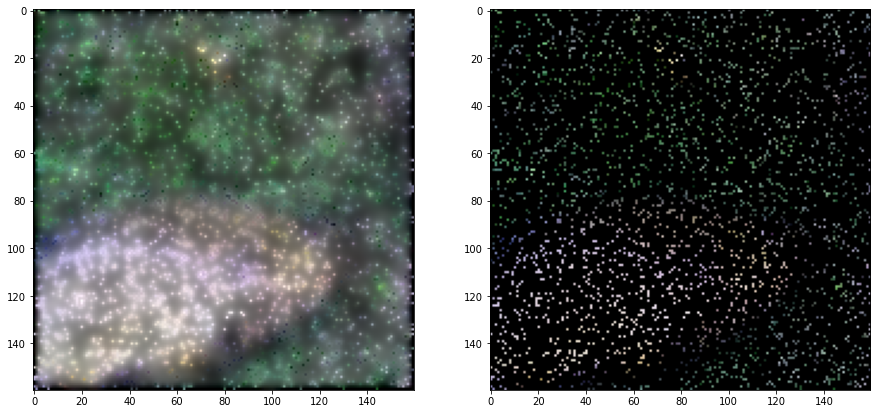

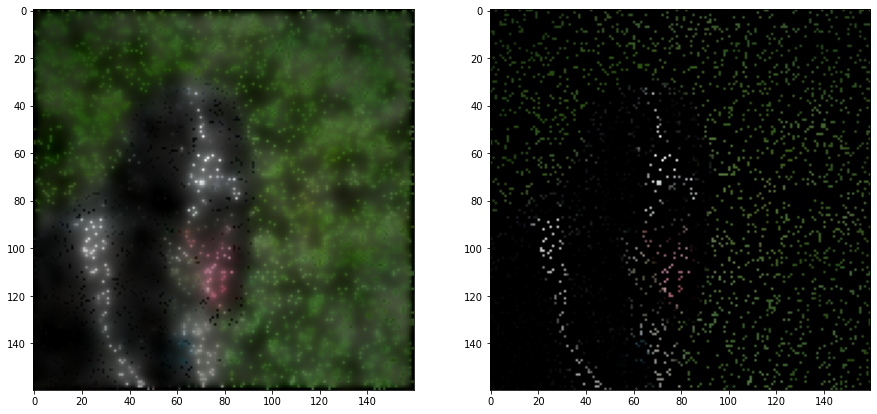

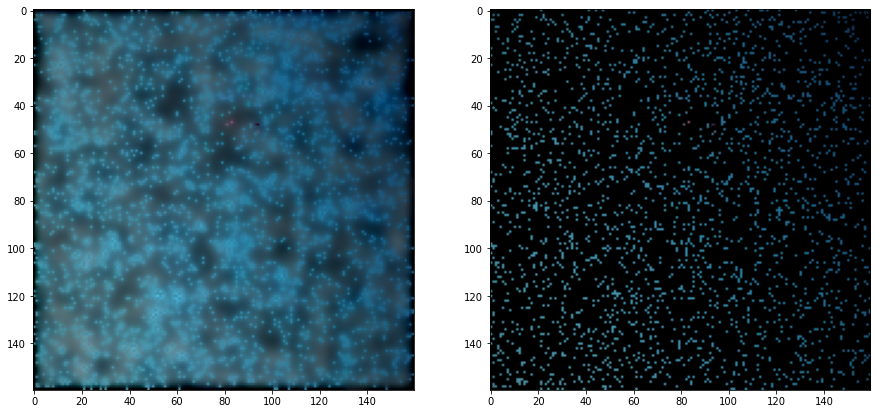

In [20]:
for i in range(10):
    plot(i)